# Sentimental Analysi for Airline Twitter data

# Importing library

In [ ]:
import pandas as pd
import numpy as np
import re
import os
import nltk
import nltk as nlp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

# Read the Dataset

In [58]:
airline_tweets = pd.read_csv('Tweets.csv')

In [59]:
airline_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Data Preprocessing

In [60]:
airline_tweets.shape

(14640, 15)

In [61]:
airline_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

# Columns

In [62]:
airline_tweets.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

# NA values or nulls in each column

In [63]:
print("Shape of the dataframe is",airline_tweets.shape)
print("The number of nulls in each column are \n", airline_tweets.isna().sum())

Shape of the dataframe is (14640, 15)
The number of nulls in each column are 
 tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


# Calculate the percentage of nulls or NA values in each column

In [64]:
print("Percentage null or na values in airline_tweets")
((airline_tweets.isnull() | airline_tweets.isna()).sum() * 100 / airline_tweets.index.size).round(2)

Percentage null or na values in airline_tweets


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

 tweet_coord , airline_sentiment_gold, negativereason_gold have more 
than 90% missing data. It will be better to delete these columns as they will not provide any constructive information.

# Delete useless columns

In [65]:
del airline_tweets['tweet_coord']
del airline_tweets['airline_sentiment_gold']
del airline_tweets['negativereason_gold']

In [66]:
airline_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Count of negative reason

In [67]:
airline_tweets.negativereason.value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

# The plot of count of nagative reasons for every airlines

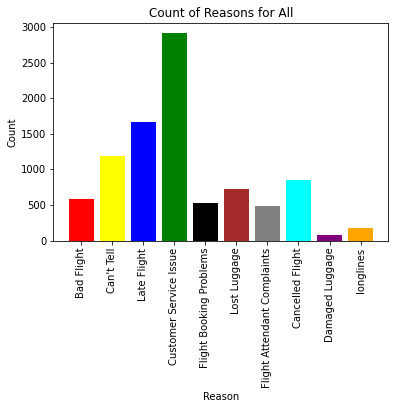

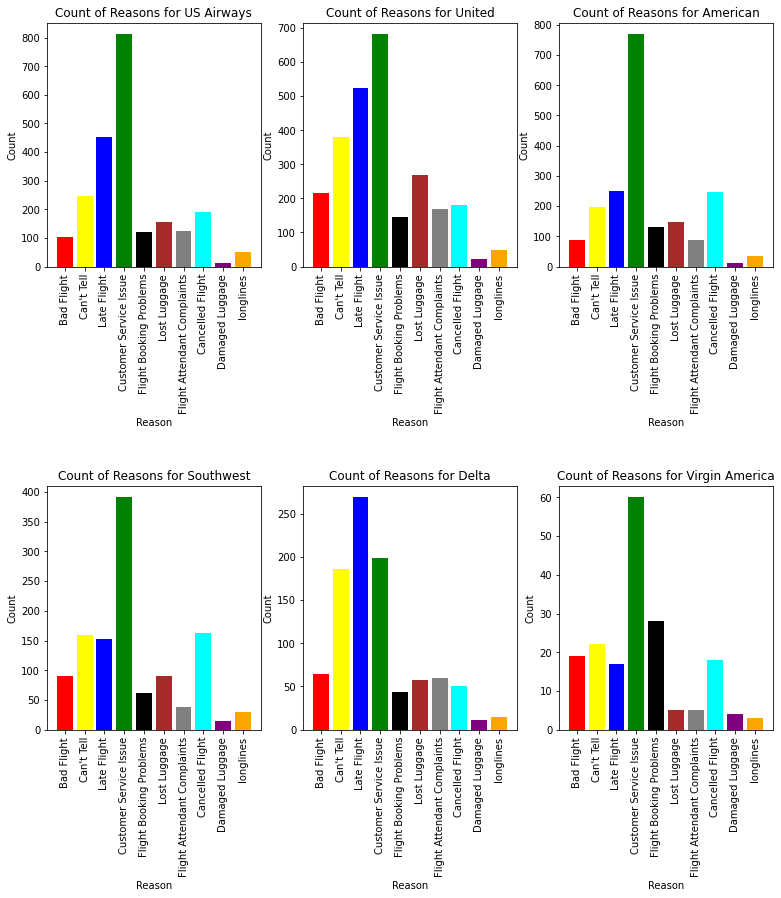

In [68]:
airline_tweets['negativereason'].nunique()  # nunique() is used to get a count of unique values.

NR_Count=dict(airline_tweets['negativereason'].value_counts(sort=False))
def NR_Count(Airline):
    if Airline=='All':
        a=airline_tweets
    else:
        a=airline_tweets[airline_tweets['airline']==Airline]
    count=dict(a['negativereason'].value_counts())
    Unique_reason=list(airline_tweets['negativereason'].unique())
    Unique_reason=[x for x in Unique_reason if str(x) != 'nan']
    Reason_frame=pd.DataFrame({'Reasons':Unique_reason})
    Reason_frame['count']=Reason_frame['Reasons'].apply(lambda x: count[x])
    return Reason_frame

def plot_reason(Airline):
    
    a=NR_Count(Airline)
    count=a['count']
    Index = range(1,(len(a)+1))
    plt.bar(Index,count, color=['red','yellow','blue','green','black','brown','gray','cyan','purple','orange'])
    plt.xticks(Index,a['Reasons'],rotation=90)
    plt.ylabel('Count')
    plt.xlabel('Reason')
    plt.title('Count of Reasons for '+Airline)
    
plot_reason('All')
plt.figure(2,figsize=(13, 13))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    plt.subplots_adjust(hspace=0.9)
    plot_reason(i)

# Plotting all the negative reasons

Text(0, 0.5, 'No. of Tweets')

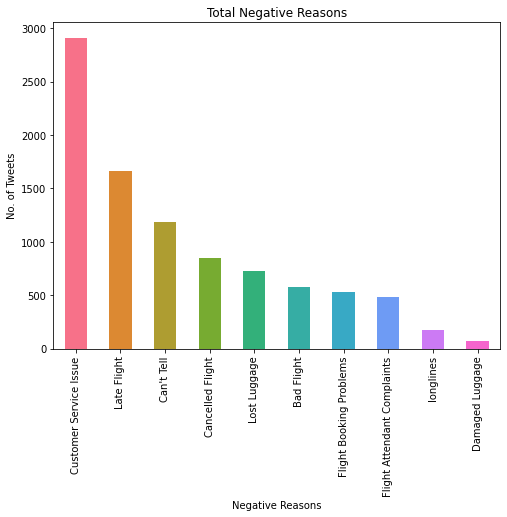

In [69]:
 color=sns.color_palette("husl", 10)
pd.Series(airline_tweets["negativereason"]).value_counts().plot(kind = "bar",
                        color=color,figsize=(8,6),title = "Total Negative Reasons")
plt.xlabel('Negative Reasons', fontsize=10)
plt.ylabel('No. of Tweets', fontsize=10)

# Count of airline sentiment

In [70]:
airline_tweets.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

# Airline sentiments for each airline

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


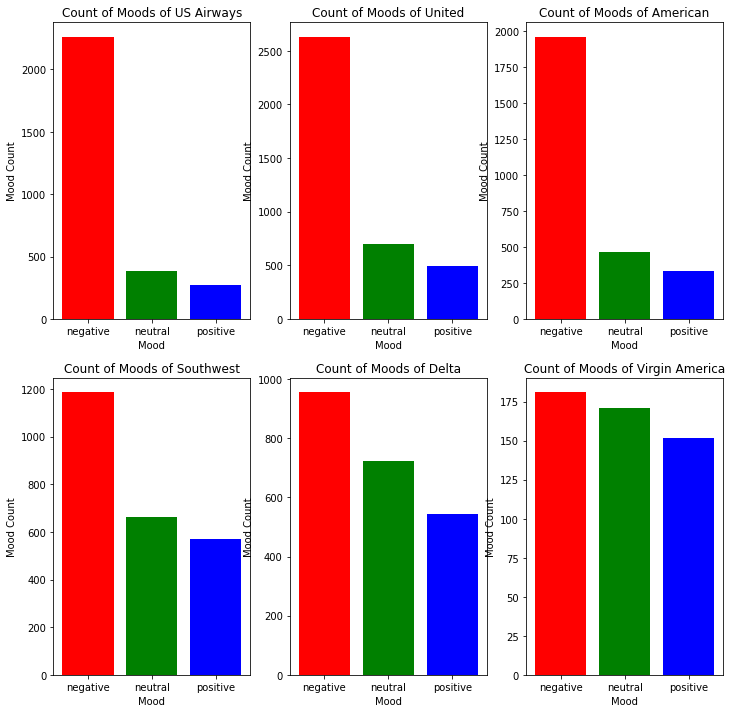

In [71]:
print("Total number of tweets for each airline \n ",airline_tweets.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']
plt.figure(1,figsize=(12, 12))
for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_airline_tweets=airline_tweets[airline_tweets['airline']==i]
    count=new_airline_tweets['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=['red', 'green', 'blue'])
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of '+i)

# Airline sentiment pie plot

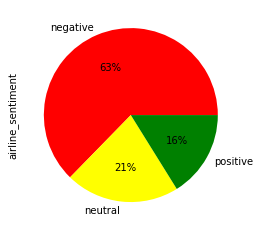

In [72]:
airline_tweets.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%', colors=["red", "yellow", "green"])

# Show the sentiments of tweets for each date from 2015-02-16 to 2015-02-24 

In [73]:
date = airline_tweets.reset_index()
#convert the Date column to pandas datetime
date.tweet_created = pd.to_datetime(date.tweet_created)
#Reduce the dates in the date column to only the date and no time stamp using the 'dt.date' method
date.tweet_created = date.tweet_created.dt.date
date.tweet_created.head()
airline_tweets = date
day_airline_tweets = airline_tweets.groupby(['tweet_created','airline','airline_sentiment']).size()
# day_airline_tweets = day_airline_tweets.reset_index()
day_airline_tweets

tweet_created  airline         airline_sentiment
2015-02-16     Delta           negative               1
                               neutral                1
               United          negative               2
2015-02-17     Delta           negative             108
                               neutral               86
                                                   ... 
2015-02-24     United          neutral               49
                               positive              25
               Virgin America  negative              10
                               neutral                6
                               positive              13
Length: 136, dtype: int64

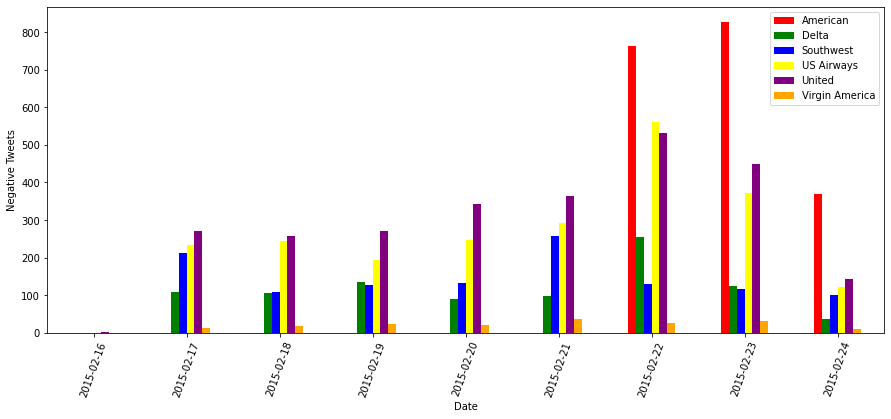

In [74]:
day_airline_tweets = day_airline_tweets.loc(axis=0)[:,:,'negative']

#groupby and plot data
ax2 = day_airline_tweets.groupby(['tweet_created','airline']).sum().unstack().plot(kind = 'bar', color=['red', 'green', 'blue','yellow','purple','orange'], figsize = (15,6), rot = 70)
labels = ['American','Delta','Southwest','US Airways','United','Virgin America']
ax2.legend(labels = labels)
ax2.set_xlabel('Date')
ax2.set_ylabel('Negative Tweets')
plt.show()

# Use of two columns for modeling

In [75]:
data = airline_tweets[['text','airline_sentiment']]
data

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


# Clean up the dataset, considering only positive and negative tweets.

In [77]:
data = data[data.airline_sentiment != "neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())  #x.lower(): returns a copy of the string in which all case-based characters have been lowercased
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) #re.sub(): replaces all occurrences of the RE pattern in string with repl
print(data[ data['airline_sentiment'] == 'positive'].size)
print(data[ data['airline_sentiment'] == 'negative'].size)
print(data[ data['airline_sentiment'] == 'negative'])
print(data[ data['airline_sentiment'] == 'positive'])

4726
18356
                                                    text airline_sentiment
3      virginamerica its really aggressive to blast o...          negative
4      virginamerica and its a really big bad thing a...          negative
5      virginamerica seriously would pay 30 a flight ...          negative
15            virginamerica sfopdx schedule is still mia          negative
17     virginamerica  i flew from nyc to sfo last wee...          negative
...                                                  ...               ...
14631  americanair thx for nothing on getting us out ...          negative
14633  americanair my flight was cancelled flightled ...          negative
14634           americanair right on cue with the delays          negative
14636  americanair leaving over 20 minutes late fligh...          negative
14638  americanair you have my money you change my fl...          negative

[9178 rows x 2 columns]
                                                    text airline

# Declaring Dataset

In [ ]:
Y = pd.get_dummies(data['airline_sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

# Selecting Some Data for Training and Some for Validation

In [ ]:
X_val = X_train[:500]
Y_val = Y_train[:500]

In [ ]:
partial_X_train = X_train[500:]
partial_Y_train = Y_train[500:]

# Tokenization

In [78]:
max_fatures = 2000
#splitting up a larger body of text into smaller lines
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
#transforms a list of num_samples sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

# Neural Network

In [79]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(Dropout(0.5))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 128)           256000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


# Train the Network

In [83]:
batch_size = 512
history = model.fit(partial_X_train, 
                    partial_Y_train, 
                    epochs = 10, 
                    batch_size=batch_size, 
                    validation_data=(X_val, Y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 7232 samples, validate on 500 samples
Epoch 1/10
7232/7232 [==============================] - 12s 2ms/step - loss: 0.5556 - accuracy: 0.7788 - val_loss: 0.4154 - val_accuracy: 0.8140
Epoch 2/10
7232/7232 [==============================] - 12s 2ms/step - loss: 0.3990 - accuracy: 0.8261 - val_loss: 0.3516 - val_accuracy: 0.8420
Epoch 3/10
7232/7232 [==============================] - 11s 2ms/step - loss: 0.3204 - accuracy: 0.8552 - val_loss: 0.2689 - val_accuracy: 0.8900
Epoch 4/10
7232/7232 [==============================] - 11s 2ms/step - loss: 0.2368 - accuracy: 0.9078 - val_loss: 0.2066 - val_accuracy: 0.9200
Epoch 5/10
7232/7232 [==============================] - 11s 2ms/step - loss: 0.1854 - accuracy: 0.9304 - val_loss: 0.1861 - val_accuracy: 0.9340
Epoch 6/10
7232/7232 [==============================] - 11s 2ms/step - loss: 0.1554 - accuracy: 0.9400 - val_loss: 0.1743 - val_accuracy: 0.9320
Epoch 7/10
7232/7232 [==============================] - 11s 2ms/step - loss: 0.1365

# Summarize history for loss

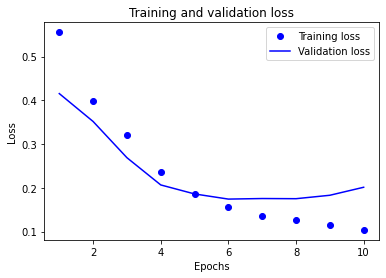

In [84]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Summarize history for accuracy

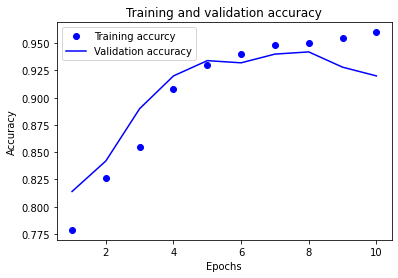

In [85]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training accurcy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Model testing

In [86]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_val)):
    
    result = model.predict(X_val[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_val[x]):
        if np.argmax(Y_val[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_val[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1
print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

pos_acc 82.0754716981132 %
neg_acc 94.67005076142132 %
